# Preparation

In [1]:
%%capture
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    roc_auc_score,
    f1_score,
    accuracy_score
)
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
import xgboost as xgb

from catboost import Pool, CatBoostClassifier, cv

SEED = 2112
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("/content/drive/MyDrive/applied_ai_enes_safak/datasets/creditcard.csv")

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d",cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
  plt.xlabel("Prediction")
  plt.ylabel("Ground Truth")

# Isolation Forest

In [441]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [442]:
train_df['Class'] = np.where(train_df.Class == 0, 1, -1)
test_df['Class'] = np.where(test_df.Class == 0, 1, -1)

In [443]:
X_train = train_df.drop(['Class'], axis = 1)
y_train = train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

In [451]:
clfIF = IsolationForest(
    max_samples=0.25, 
    random_state=SEED, 
    contamination=0.05,#
    n_estimators=30, 
    n_jobs=-1
)

In [452]:
clfIF.fit(X_train, y_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=0.25, n_estimators=30, n_jobs=-1,
                random_state=2112, verbose=0, warm_start=False)

In [453]:
y_pred_test = clfIF.predict(X_test)

In [454]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.03      0.86      0.06       173
           1       1.00      0.95      0.97     93814

    accuracy                           0.95     93987
   macro avg       0.52      0.90      0.52     93987
weighted avg       1.00      0.95      0.97     93987



In [455]:
cm = confusion_matrix(y_test, y_pred_test)
df_cm = pd.DataFrame(
    cm,
    index = ["-1","1"], columns=["-1","1"]
)

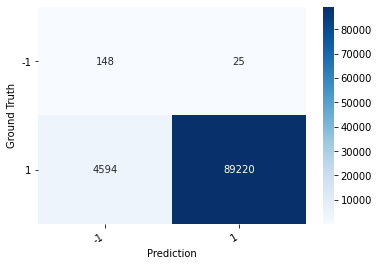

In [456]:
show_confusion_matrix(df_cm)

# Isolation Forest With Subsampling

In [457]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [458]:
train_df['Class'] = np.where(train_df.Class == 0, 1, -1)
test_df['Class'] = np.where(test_df.Class == 0, 1, -1)
print(train_df[train_df["Class"] == -1].shape[0], train_df[train_df["Class"] == 1].shape[0])

319 190501


In [459]:
n_samples = train_df[train_df["Class"] == 1].shape[0] // 35
anomalies = train_df[train_df["Class"] == -1].reset_index(drop=True)
subsample_normal = train_df[train_df["Class"] == 1].sample(n=n_samples, random_state=SEED).reset_index(drop=True)

sub_train_df = pd.concat([subsample_normal, anomalies], axis=0).sample(frac=1).reset_index(drop=True)
print(sub_train_df[sub_train_df["Class"] == -1].shape[0], sub_train_df[sub_train_df["Class"] == 1].shape[0])

319 5442


In [460]:
X_train = sub_train_df.drop(['Class'], axis = 1)
y_train = sub_train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

In [466]:
clfIF = IsolationForest(
    max_samples = 0.25,
    contamination = 0.25,
    random_state=SEED, 
    n_estimators=30, 
    n_jobs=-1)

In [467]:
clfIF.fit(X_train, y_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.25,
                max_features=1.0, max_samples=0.25, n_estimators=30, n_jobs=-1,
                random_state=2112, verbose=0, warm_start=False)

In [468]:
y_pred_test = clfIF.predict(X_test)

In [469]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.01      0.92      0.02       173
           1       1.00      0.79      0.88     93814

    accuracy                           0.79     93987
   macro avg       0.50      0.86      0.45     93987
weighted avg       1.00      0.79      0.88     93987



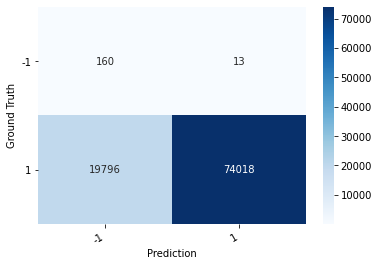

In [470]:
cm = confusion_matrix(y_test, y_pred_test)
df_cm = pd.DataFrame(
    cm,
    index = ["-1","1"], columns=["-1","1"]
)
show_confusion_matrix(df_cm)

# Local Outlier Factor

In [471]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [472]:
train_df['Class'] = np.where(train_df.Class == 0, 1, -1)
test_df['Class'] = np.where(test_df.Class == 0, 1, -1)

In [473]:
X_train = train_df.drop(['Class'], axis = 1)
y_train = train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

In [498]:
clfLOF = LocalOutlierFactor(
    n_neighbors=7, 
    metric='manhattan', 
    algorithm='auto', 
    contamination=0.05, 
    n_jobs=-1,
)

In [499]:
clfLOF.fit(X_train, y_train)

LocalOutlierFactor(algorithm='auto', contamination=0.05, leaf_size=30,
                   metric='manhattan', metric_params=None, n_jobs=-1,
                   n_neighbors=7, novelty=False, p=2)

In [500]:
y_pred_test = clfLOF.fit_predict(X_test)

In [501]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.02      0.65      0.05       173
           1       1.00      0.95      0.97     93814

    accuracy                           0.95     93987
   macro avg       0.51      0.80      0.51     93987
weighted avg       1.00      0.95      0.97     93987



In [502]:
cm = confusion_matrix(y_test, y_pred_test)
df_cm = pd.DataFrame(
    cm,
    index = ["-1","1"], columns=["-1","1"]
)

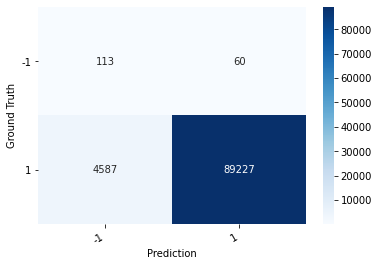

In [503]:
show_confusion_matrix(df_cm)

# Local Outlier Factor With Subsampling

In [545]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [546]:
train_df['Class'] = np.where(train_df.Class == 0, 1, -1)
test_df['Class'] = np.where(test_df.Class == 0, 1, -1)

In [547]:
n_samples = train_df[train_df["Class"] == 1].shape[0] // 200
anomalies = train_df[train_df["Class"] == -1].reset_index(drop=True)
subsample_normal = train_df[train_df["Class"] == 1].sample(n=n_samples, random_state=SEED).reset_index(drop=True)

sub_train_df = pd.concat([subsample_normal, anomalies], axis=0).sample(frac=1).reset_index(drop=True)
print(sub_train_df[sub_train_df["Class"] == -1].shape[0], sub_train_df[sub_train_df["Class"] == 1].shape[0])

319 952


In [548]:
X_train = sub_train_df.drop(['Class'], axis = 1)
y_train = sub_train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

In [588]:
clfLOF = LocalOutlierFactor(
    n_neighbors=7, 
    metric='l1', 
    algorithm='auto', 
    contamination=0.10,#len(y_train[y_train == -1])/len(y_train[y_train == 1]), 
    n_jobs=-1,
)

In [589]:
clfLOF.fit(X_train, y_train)

LocalOutlierFactor(algorithm='auto', contamination=0.1, leaf_size=30,
                   metric='l1', metric_params=None, n_jobs=-1, n_neighbors=7,
                   novelty=False, p=2)

In [590]:
y_pred_test = clfLOF.fit_predict(X_test)

In [591]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.01      0.75      0.03       173
           1       1.00      0.90      0.95     93814

    accuracy                           0.90     93987
   macro avg       0.51      0.82      0.49     93987
weighted avg       1.00      0.90      0.95     93987



In [592]:
cm = confusion_matrix(y_test, y_pred_test)
df_cm = pd.DataFrame(
    cm,
    index = ["-1","1"], columns=["-1","1"]
)

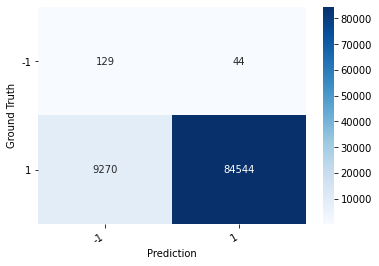

In [593]:
show_confusion_matrix(df_cm)

# XGBoost

In [6]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [19]:
def lets_make_some_xgb(X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5,  early_stopping_rounds=50):
  clf = XGBClassifier(
      learning_rate=0.1, 
      n_estimators=140, 
      max_depth=5,
      min_child_weight=3, 
      gamma=0.2, 
      subsample=0.6,
      colsample_bytree=0.6,
      objective='binary:logistic', 
      nthread=4, 
      scale_pos_weight=20, 
      seed=27,
      tree_method = "gpu_hist"
  )

  if useTrainCV:
    print("Started cross-validation...")
    xgb_param = clf.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    cvresult = xgb.cv(
        xgb_param, 
        xgtrain, 
        num_boost_round=clf.get_params()['n_estimators'], 
        nfold=cv_folds,
        early_stopping_rounds=early_stopping_rounds
    )
    clf.set_params(n_estimators=cvresult.shape[0])
  print('Started Training...')
  clf.fit(X_train, y_train, eval_metric='auc')

  print("Started Predicting...")
  predictions = clf.predict(X_test)
  pred_proba = clf.predict_proba(X_test)[:, 1]

  print("\nResulting Metrics")
  print("Accuracy : %.4g" % accuracy_score(y_test, predictions))
  print("AUC : %f" % roc_auc_score(y_test, pred_proba))
  print("F1 Score : %f" % f1_score(y_test, predictions))
  print()
  print(f"{classification_report(y_test, predictions)}")
  print()
  cm = confusion_matrix(y_test, predictions)
  df_cm = pd.DataFrame(
      cm,
      index = ["0","1"], columns=["0","1"]
  )
  show_confusion_matrix(df_cm)
  print()

  feat_imp = clf.feature_importances_
  feat = X_train.columns.tolist()
  res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
  res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
  plt.ylabel('Feature Importance Score')
  plt.show()
  print(res_df)
  print(res_df["Features"].tolist())
  return clf

In [20]:
X_train = train_df.drop(['Class'], axis = 1)
y_train = train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

Started cross-validation...
Started Training...
Started Predicting...

Resulting Metrics
Accuracy : 0.9996
AUC : 0.985039
F1 Score : 0.875776

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93814
           1       0.95      0.82      0.88       173

    accuracy                           1.00     93987
   macro avg       0.97      0.91      0.94     93987
weighted avg       1.00      1.00      1.00     93987





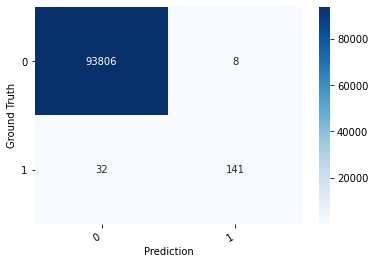

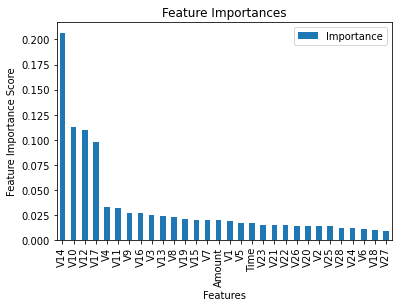

   Features  Importance
14      V14    0.206884
10      V10    0.112688
12      V12    0.109912
17      V17    0.097805
4        V4    0.032179
11      V11    0.031522
9        V9    0.026765
16      V16    0.026674
3        V3    0.024978
13      V13    0.023629
8        V8    0.022582
19      V19    0.020566
15      V15    0.019934
7        V7    0.019934
29   Amount    0.019374
1        V1    0.018434
5        V5    0.016630
0      Time    0.016514
23      V23    0.015023
21      V21    0.014945
22      V22    0.014287
26      V26    0.014155
20      V20    0.014104
2        V2    0.014098
25      V25    0.013489
28      V28    0.011912
24      V24    0.011179
6        V6    0.011123
18      V18    0.009896
27      V27    0.008785
['V14', 'V10', 'V12', 'V17', 'V4', 'V11', 'V9', 'V16', 'V3', 'V13', 'V8', 'V19', 'V15', 'V7', 'Amount', 'V1', 'V5', 'Time', 'V23', 'V21', 'V22', 'V26', 'V20', 'V2', 'V25', 'V28', 'V24', 'V6', 'V18', 'V27']


In [21]:
clf = lets_make_some_xgb(X_train, X_test, y_train, y_test, useTrainCV=True)

# XGBoost With Subsampling

In [51]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [52]:
n_samples = train_df[train_df["Class"] == 0].shape[0] // 15
anomalies = train_df[train_df["Class"] == 1].reset_index(drop=True)
subsample_normal = train_df[train_df["Class"] == 0].sample(n=n_samples, random_state=SEED).reset_index(drop=True)

sub_train_df = pd.concat([subsample_normal, anomalies], axis=0).sample(frac=1).reset_index(drop=True)
print(sub_train_df[sub_train_df["Class"] == 0].shape[0], sub_train_df[sub_train_df["Class"] == 1].shape[0])

12700 319


In [53]:
X_train = sub_train_df.drop(['Class'], axis = 1)
y_train = sub_train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

Started cross-validation...
Started Training...
Started Predicting...

Resulting Metrics
Accuracy : 0.9986
AUC : 0.989380
F1 Score : 0.683721

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93814
           1       0.57      0.85      0.68       173

    accuracy                           1.00     93987
   macro avg       0.79      0.92      0.84     93987
weighted avg       1.00      1.00      1.00     93987





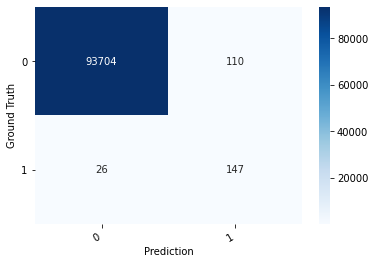

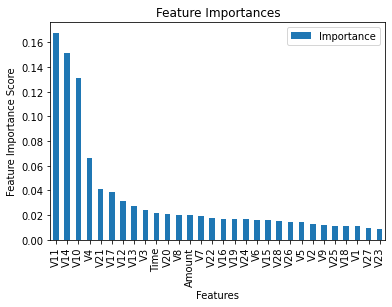

   Features  Importance
11      V11    0.167779
14      V14    0.151345
10      V10    0.130727
4        V4    0.065934
21      V21    0.041173
17      V17    0.038774
12      V12    0.031367
13      V13    0.027234
3        V3    0.024417
0      Time    0.021430
20      V20    0.020741
8        V8    0.020324
29   Amount    0.020023
7        V7    0.019364
22      V22    0.017303
16      V16    0.016987
19      V19    0.016576
24      V24    0.016510
6        V6    0.016197
15      V15    0.015621
28      V28    0.014812
26      V26    0.014585
5        V5    0.014246
2        V2    0.012579
9        V9    0.012082
25      V25    0.011446
18      V18    0.010901
1        V1    0.010754
27      V27    0.009821
23      V23    0.008947
['V11', 'V14', 'V10', 'V4', 'V21', 'V17', 'V12', 'V13', 'V3', 'Time', 'V20', 'V8', 'Amount', 'V7', 'V22', 'V16', 'V19', 'V24', 'V6', 'V15', 'V28', 'V26', 'V5', 'V2', 'V9', 'V25', 'V18', 'V1', 'V27', 'V23']


In [54]:
clf = lets_make_some_xgb(X_train, X_test, y_train, y_test, useTrainCV=True)

# Catboost

In [7]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [8]:
X_train = train_df.drop(['Class'], axis = 1)
y_train = train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

In [11]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.02,
    depth=12,
    eval_metric='AUC',
    random_seed = SEED,
    bagging_temperature = 0.2,
    od_type='Iter',
    od_wait=100,
    task_type="GPU",
    verbose=0
)

model.fit(X_train,y_train,eval_set=(X_test,y_test))


Resulting Metrics
Accuracy : 0.9996
AUC : 0.980661
F1 Score : 0.876190

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93814
           1       0.97      0.80      0.88       173

    accuracy                           1.00     93987
   macro avg       0.99      0.90      0.94     93987
weighted avg       1.00      1.00      1.00     93987




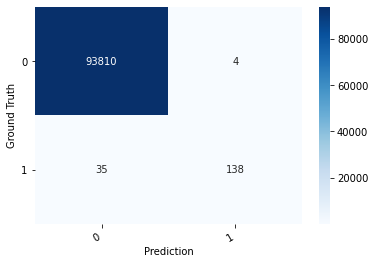

In [12]:
predictions = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

print("\nResulting Metrics")
print("Accuracy : %.4g" % accuracy_score(y_test, predictions))
print("AUC : %f" % roc_auc_score(y_test, pred_proba))
print("F1 Score : %f" % f1_score(y_test, predictions))

print()
print(f"{classification_report(y_test, predictions)}")
print()
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(
    cm,
    index = ["0","1"], columns=["0","1"]
)
show_confusion_matrix(df_cm)

# Catboost Hyperparameter Optimization

In [7]:
train_df, test_df = train_test_split(df,test_size=0.33, random_state=SEED)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)
print(train_df.shape, test_df.shape)

(190820, 31) (93987, 31)


In [8]:
X_train = train_df.drop(['Class'], axis = 1)
y_train = train_df['Class']

X_test = test_df.drop(['Class'], axis = 1)
y_test = test_df['Class']

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  

model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.02,
    depth=12,
    eval_metric='AUC',
    random_seed = SEED,
    bagging_temperature = 0.2,
    od_type='Iter',
    od_wait=100,
    verbose=0
)

parameters = {'depth'         : sp_randInt(1, 20),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(10, 200)
}
    
randm = RandomizedSearchCV(
    estimator=model, 
    param_distributions = 
    parameters, 
    cv = 2, 
    n_iter = 10, 
    n_jobs=-1
)
randm.fit(X_train, y_train, eval_set=(X_test,y_test))

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f5310eb3690>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5310eb3710>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5310eb3990>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5310eb3750>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

Start Predicting

Resulting Metrics
Accuracy : 0.9996
AUC : 0.981785
F1 Score : 0.869841

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93814
           1       0.96      0.79      0.87       173

    accuracy                           1.00     93987
   macro avg       0.98      0.90      0.93     93987
weighted avg       1.00      1.00      1.00     93987




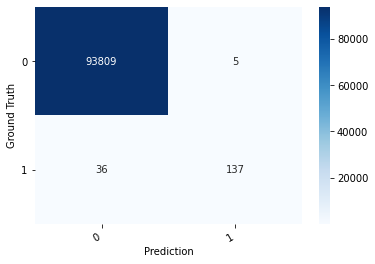

In [11]:
print("Start Predicting")
predictions = randm.best_estimator_.predict(X_test)
pred_proba = randm.best_estimator_.predict_proba(X_test)[:, 1]

print("\nResulting Metrics")
print("Accuracy : %.4g" % accuracy_score(y_test, predictions))
print("AUC : %f" % roc_auc_score(y_test, pred_proba))
print("F1 Score : %f" % f1_score(y_test, predictions))

print()
print(f"{classification_report(y_test, predictions)}")
print()
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(
    cm,
    index = ["0","1"], columns=["0","1"]
)
show_confusion_matrix(df_cm)